<a href="https://www.kaggle.com/code/uom180281j/ml-project-dataprocess?scriptVersionId=116424005" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import cupy, cudf # GPU libraries

from itertools import cycle
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

import warnings, gc
warnings.filterwarnings('ignore')

# Common Functions

In [14]:
# Function for model Evaluation
def evaluate(y_test , y_pred):
    print("MAE",mean_absolute_error(y_test,y_pred) , '\n')
    
    print("MSE",mean_squared_error(y_test,y_pred), '\n')
    
    print("RMSE",np.sqrt(mean_squared_error(y_test,y_pred)), '\n')
    
    print("RMSLE",np.log(np.sqrt(mean_squared_error(y_test,y_pred))), '\n')
    
    r2 = r2_score(y_test,y_pred)
    print("R Squared",r2, '\n')
    
    Adj_r2 = 1-(1-r2)*(5950-1)/(5950-4-1)
    print("Adjusted R Squared",Adj_r2, '\n')
    
    accuracy = accuracy_score(y_test, y_pred, normalize=True)
    print("Accuracy",accuracy, '\n')
    
def fillmissmeadian(dframe):
    for column in dframe.columns:
        median = dframe[column].median()
        dframe[column] = dframe[column].fillna(median)
    return dframe

def fillmissmean(dframe):
    for column in dframe.columns:
        mean = dframe[column].mean()
        dframe[column] = dframe[column].fillna(mean)
    return dframe

#Detecting outliers using the Z-scores

def detect_outliers_zscore(data):
    outliers=[]
    thres = 3
    mean = np.mean(data)
    std = np.std(data)
    # print(mean, std)
    for i in data:
        z_score = (i-mean)/std
        if (np.abs(z_score) > thres):
            outliers.append(i)
    print(outliers)
    return outliers

def replace_outliers(data):
    outliers=detect_outliers_zscore(data)
    median = np.median(data)
    for i in outliers:
        data.replace(i,median,inplace=True) #Replace with median
    return data

In [6]:
# AMEX Metric
def amex_metric(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:

    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
        
    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d)

# Load Data

In [7]:
df_train = pd.read_feather('../input/amexfeather/train_data.ftr')
# Keep the latest statement features for each customer
df_train = df_train.groupby('customer_ID').tail(1).set_index('customer_ID')

df_test = pd.read_feather('../input/amexfeather/test_data.ftr')
# Keep the latest statement features for each customer
df_test = df_test.groupby('customer_ID').tail(1).set_index('customer_ID')

df_subm = pd.read_csv("../input/amex-default-prediction/sample_submission.csv")

In [16]:
df_train_row_count, df_train_column_count=df_train.shape
print('Total amount of rows (Train):', df_train_row_count)
print('Total amount of columns (Train):', df_train_column_count)

Total amount of rows (Train): 458913
Total amount of columns (Train): 190


In [17]:
df_test_row_count, df_test_column_count=df_test.shape
print('Total amount of rows (Test):', df_test_row_count)
print('Total amount of columns (Test):', df_test_column_count)

Total amount of rows (Test): 924621
Total amount of columns (Test): 189


In [18]:
df_train

,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
customer_ID,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,2018-03-13,0.934570,0.009117,0.009384,1.007812,0.006104,0.135010,0.001604,0.007175,0.108276,...,0.005051,0.007027,0.007187,0.004234,0.005085,0.385986,0.005810,0.002970,0.008530,0
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,2018-03-25,0.880371,0.178101,0.034698,1.003906,0.006912,0.165527,0.005550,0.005070,0.108276,...,0.005051,0.007027,0.002981,0.007481,0.007874,0.385986,0.003284,0.003170,0.008514,0
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,2018-03-12,0.880859,0.009705,0.004284,0.812500,0.006451,0.164917,0.003796,0.007195,0.108276,...,0.005051,0.007027,0.007381,0.006622,0.000965,0.385986,0.002201,0.000834,0.003445,0
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,2018-03-29,0.621582,0.001082,0.012566,1.005859,0.007828,0.287842,0.004532,0.009941,0.108276,...,0.005051,0.007027,0.002705,0.006184,0.001899,0.385986,0.008186,0.005558,0.002983,0
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,2018-03-30,0.872070,0.005573,0.007679,0.815918,0.001247,0.164917,0.000231,0.005527,0.108276,...,0.005051,0.007027,0.002974,0.004162,0.005764,0.385986,0.008156,0.006943,0.000905,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffff41c8a52833b56430603969b9ca48d208e7c192c6a4081a6acc28cf4f8af7,2018-03-31,0.844238,0.447510,0.028519,1.009766,0.001928,0.128662,0.003483,0.005894,0.108276,...,0.005051,0.007027,0.007919,0.001519,0.005531,0.385986,0.001431,0.003010,0.004845,0
ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fdd3e5b57cfcbee30286,2018-03-22,0.831055,0.033661,0.292480,0.055664,0.006954,0.164917,0.005791,0.233032,0.108276,...,0.005051,0.007027,0.004395,0.006184,0.001479,0.385986,0.004795,0.009232,0.006435,0
ffff9984b999fccb2b6127635ed0736dda94e544e67e026eee4d20f680639ff6,2018-03-07,0.800293,0.267090,0.020569,1.006836,0.000957,0.066650,0.007423,0.006313,0.108276,...,0.005051,0.007027,0.006035,0.002869,0.002150,0.385986,0.008034,0.000340,0.002148,0


# Data Preprocessing

## Categorical Encoding

In [19]:
cat_cols = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

In [71]:
df_train[cat_cols].head()

,B_30,B_38,D_114,D_116,D_117,D_120,D_126,D_63,D_64,D_66,D_68
customer_ID,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,0.0,2.0,1.0,0.0,4.0,0.0,1.0,CR,O,NaN,6.0
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,0.0,2.0,1.0,0.0,-1.0,0.0,1.0,CO,O,NaN,6.0
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,0.0,1.0,1.0,0.0,-1.0,0.0,1.0,CO,R,NaN,6.0
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,0.0,2.0,1.0,0.0,6.0,0.0,1.0,CO,O,NaN,3.0
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,0.0,1.0,1.0,0.0,4.0,0.0,1.0,CO,O,1.0,6.0


### Label Encoder

In [20]:
from sklearn.preprocessing import LabelEncoder
lab_enc = LabelEncoder()
for cat_feat in cat_cols:
    df_train[cat_feat] = lab_enc.fit_transform(df_train[cat_feat])
    df_test[cat_feat] = lab_enc.transform(df_test[cat_feat])

### One Hot Encoder

In [73]:
# get dummies  It converts categorical data into dummy or indicator variables.
df_train = pd.get_dummies(df_train)
df_test = pd.get_dummies(df_test)

In [17]:
# from sklearn.preprocessing import OneHotEncoder
# onehot_enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
# trn_encoded_features = pd.DataFrame(onehot_enc.fit_transform(df_train[cat_cols])
# trn_encoded_features.index = df_train.index
# trn_encoded_features
# df_train = pd.concat([df_train[trn_not_cat_features], trn_encoded_features], axis = 1)
# df_train.head(5)
# for cat_feat in cat_cols:
#     df_train[cat_feat] = onehot_enc.fit_transform(df_train[cat_feat])
#     df_test[cat_feat] = onehot_enc.transform(df_test[cat_feat])

In [12]:
# df_train.info(max_cols = 300)

## Handling Missing Values - Data Imputation

### Fill missing values with median

In [21]:
df_train_miss = fillmissmeadian(df_train)
df_test_miss = fillmissmeadian(df_test)

### Fill missing values with mean

In [74]:
df_train_miss = fillmissmean(df_train)
df_test_miss = fillmissmean(df_test)

### Fill missing values wih a number

In [13]:
df_train_miss = df_train.fillna(value = 0, inplace = True)
df_test_miss = df_test.fillna(value = 0, inplace = True)

## Detecting and Handling Outliers

### Detecting Outliers with Z-score

In [ ]:
detect_outliers_zscore(df_train)

### Handling Outliers with Mean/Median Imputation

In [76]:
columns=list(df_train.columns)
columns.remove('target')
columns.remove('S_2')
columns

['P_2',
 'D_39',
 'B_1',
 'B_2',
 'R_1',
 'S_3',
 'D_41',
 'B_3',
 'D_42',
 'D_43',
 'D_44',
 'B_4',
 'D_45',
 'B_5',
 'R_2',
 'D_46',
 'D_47',
 'D_48',
 'D_49',
 'B_6',
 'B_7',
 'B_8',
 'D_50',
 'D_51',
 'B_9',
 'R_3',
 'D_52',
 'P_3',
 'B_10',
 'D_53',
 'S_5',
 'B_11',
 'S_6',
 'D_54',
 'R_4',
 'S_7',
 'B_12',
 'S_8',
 'D_55',
 'D_56',
 'B_13',
 'R_5',
 'D_58',
 'S_9',
 'B_14',
 'D_59',
 'D_60',
 'D_61',
 'B_15',
 'S_11',
 'D_62',
 'D_65',
 'B_16',
 'B_17',
 'B_18',
 'B_19',
 'B_20',
 'S_12',
 'R_6',
 'S_13',
 'B_21',
 'D_69',
 'B_22',
 'D_70',
 'D_71',
 'D_72',
 'S_15',
 'B_23',
 'D_73',
 'P_4',
 'D_74',
 'D_75',
 'D_76',
 'B_24',
 'R_7',
 'D_77',
 'B_25',
 'B_26',
 'D_78',
 'D_79',
 'R_8',
 'R_9',
 'S_16',
 'D_80',
 'R_10',
 'R_11',
 'B_27',
 'D_81',
 'D_82',
 'S_17',
 'R_12',
 'B_28',
 'R_13',
 'D_83',
 'R_14',
 'R_15',
 'D_84',
 'R_16',
 'B_29',
 'S_18',
 'D_86',
 'D_87',
 'R_17',
 'R_18',
 'D_88',
 'B_31',
 'S_19',
 'R_19',
 'B_32',
 'S_20',
 'R_20',
 'R_21',
 'B_33',
 'D_89',
 

In [ ]:
for i in columns:
    print(i)
    replace_outliers(train_set[i])
    # replace_outliers(df_test[i])

## Data Discretization with Histogram Analysis

### Skewness Representation

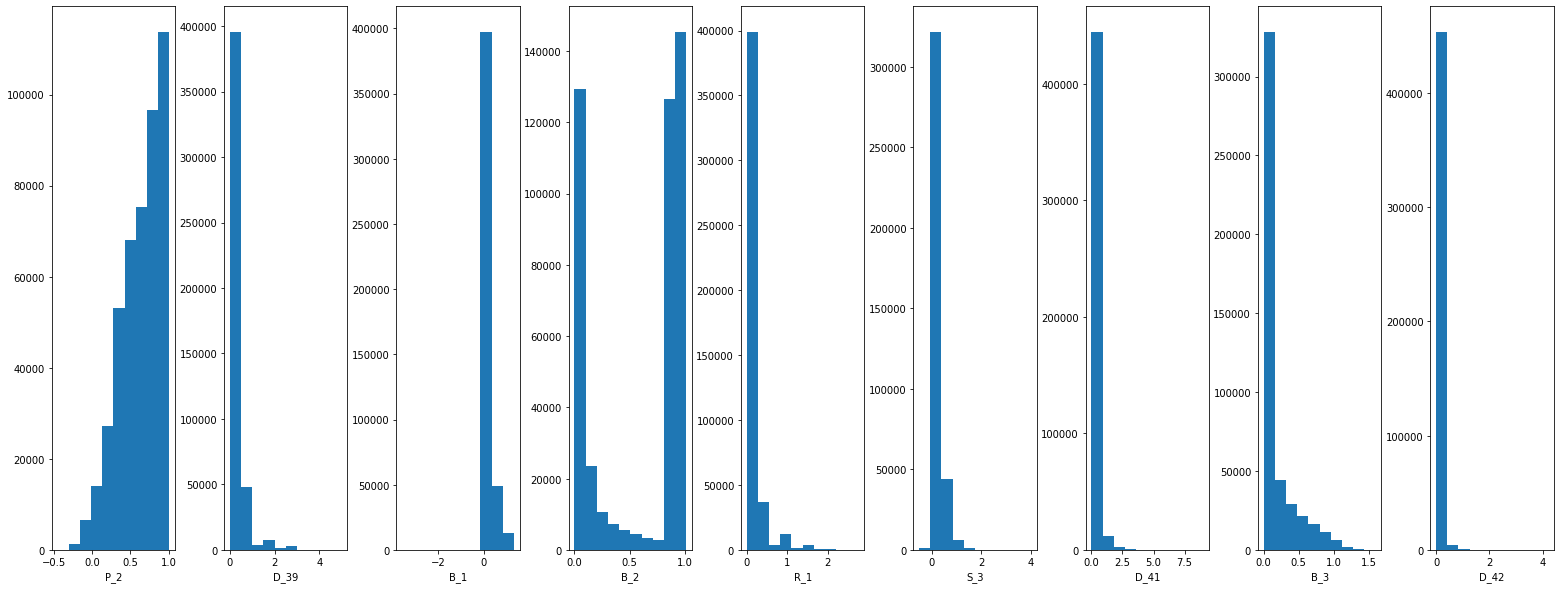

In [82]:
fig = plt.figure(figsize=(30,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(1,10):
  fig.add_subplot(1,10,i)
  plt.hist(x=df_train[columns[i-1]])
  plt.xlabel(columns[i-1])

In [83]:
df_train.skew().sort_values(ascending=False)

D_63_XL      23.769036
D_116_1.0    18.480650
D_63_XM      17.387829
D_63_XZ      11.732412
B_30_2.0      9.763263
               ...    
D_141              NaN
D_142              NaN
D_143              NaN
D_144              NaN
D_145              NaN
Length: 224, dtype: float64

In [ ]:
# from scipy import stats
# df_train['D_63_XL']=pd.Series(stats.boxcox(df_train['D_63_XL'])[0])
# df_train['D_63_XL']=pd.Series(stats.boxcox(df_train['D_63_XL'])[0])

## Feature Creation

In [22]:
features_avg = ['B_11', 'B_13', 'B_14', 'B_15', 'B_16', 'B_17', 'B_18', 'B_19', 'B_2', 
                'B_20', 'B_28', 'B_29', 'B_3', 'B_33', 'B_36', 'B_37', 'B_4', 'B_42', 
                'B_5', 'B_8', 'B_9', 'D_102', 'D_103', 'D_105', 'D_111', 'D_112', 'D_113', 
                'D_115', 'D_118', 'D_119', 'D_121', 'D_124', 'D_128', 'D_129', 'D_131', 
                'D_132', 'D_133', 'D_139', 'D_140', 'D_141', 'D_143', 'D_144', 'D_145', 
                'D_39', 'D_41', 'D_42', 'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 
                'D_49', 'D_50', 'D_51', 'D_52', 'D_56', 'D_58', 'D_62', 'D_70', 'D_71', 
                'D_72', 'D_74', 'D_75', 'D_79', 'D_81', 'D_83', 'D_84', 'D_88', 'D_91', 
                'P_2', 'P_3', 'R_1', 'R_10', 'R_11', 'R_13', 'R_18', 'R_19', 'R_2', 'R_26', 
                'R_27', 'R_28', 'R_3', 'S_11', 'S_12', 'S_22', 'S_23', 'S_24', 'S_26', 
                'S_27', 'S_5', 'S_7', 'S_8', ]
features_min = ['B_13', 'B_14', 'B_15', 'B_16', 'B_17', 'B_19', 'B_2', 'B_20', 'B_22', 
                'B_24', 'B_27', 'B_28', 'B_29', 'B_3', 'B_33', 'B_36', 'B_4', 'B_42', 
                'B_5', 'B_9', 'D_102', 'D_103', 'D_107', 'D_109', 'D_110', 'D_111', 
                'D_112', 'D_113', 'D_115', 'D_118', 'D_119', 'D_121', 'D_122', 'D_128', 
                'D_129', 'D_132', 'D_133', 'D_139', 'D_140', 'D_141', 'D_143', 'D_144', 
                'D_145', 'D_39', 'D_41', 'D_42', 'D_45', 'D_46', 'D_48', 'D_50', 'D_51', 
                'D_53', 'D_54', 'D_55', 'D_56', 'D_58', 'D_59', 'D_60', 'D_62', 'D_70', 
                'D_71', 'D_74', 'D_75', 'D_78', 'D_79', 'D_81', 'D_83', 'D_84', 'D_86', 
                'D_88', 'D_96', 'P_2', 'P_3', 'P_4', 'R_1', 'R_11', 'R_13', 'R_17', 'R_19', 
                'R_2', 'R_27', 'R_28', 'R_4', 'R_5', 'R_8', 'S_11', 'S_12', 'S_23', 'S_25', 
                'S_3', 'S_5', 'S_7', 'S_9', ]
features_max = ['B_1', 'B_11', 'B_13', 'B_15', 'B_16', 'B_17', 'B_18', 'B_19', 'B_2', 
                'B_22', 'B_24', 'B_27', 'B_28', 'B_29', 'B_3', 'B_31', 'B_33', 'B_36', 
                'B_4', 'B_42', 'B_5', 'B_7', 'B_9', 'D_102', 'D_103', 'D_105', 'D_109', 
                'D_110', 'D_112', 'D_113', 'D_115', 'D_121', 'D_124', 'D_128', 'D_129', 
                'D_131', 'D_139', 'D_141', 'D_144', 'D_145', 'D_39', 'D_41', 'D_42', 
                'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 'D_50', 'D_51', 'D_52', 
                'D_53', 'D_56', 'D_58', 'D_59', 'D_60', 'D_62', 'D_70', 'D_72', 'D_74', 
                'D_75', 'D_79', 'D_81', 'D_83', 'D_84', 'D_88', 'D_89', 'P_2', 'P_3', 
                'R_1', 'R_10', 'R_11', 'R_26', 'R_28', 'R_3', 'R_4', 'R_5', 'R_7', 'R_8', 
                'S_11', 'S_12', 'S_23', 'S_25', 'S_26', 'S_27', 'S_3', 'S_5', 'S_7', 'S_8', ]

In [23]:
df_avg = (df_train_miss
            .groupby('customer_ID')
              .mean()[features_avg]
              .rename(columns={f: f"{f}_avg" for f in features_avg})
             )
    
df_max = (df_train_miss
              .groupby('customer_ID')
              .max()[features_max]
              .rename(columns={f: f"{f}_max" for f in features_max})
             )

df_min = (df_train_miss
             .groupby('customer_ID')
              .min()[features_min]
              .rename(columns={f: f"{f}_min" for f in features_min})
             )

In [24]:
df_train_update = pd.concat([df_train_miss, df_avg, df_min, df_max], axis=1)

In [25]:
df_train_update.shape

(458913, 466)

## Get X and Y

In [26]:
y = df_train_update['target']
X = df_train_update.drop('target', axis=1)

### Split train and test sets

In [27]:
from sklearn.model_selection import train_test_split

# creating dataset split for prediction
X_train, X_test , y_train , y_test = train_test_split(X,y,test_size=0.3,random_state=42) # 80-20 split

# Checking split 
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_train: (321239, 465)
y_train: (321239,)
X_test: (137674, 465)
y_test: (137674,)


### Drop S_2 column

In [28]:
drop_cols = ['S_2'] 
X_train.drop(drop_cols, inplace=True, axis=1)
X_test.drop(drop_cols, inplace=True, axis=1)

## Feature Scaling

In [44]:
# X_train[X_train.dtypes[(X_train.dtypes=="float64")|(X_train.dtypes=="int64")]
#                         .index.values].hist(figsize=[11,11])

### Standard Sclaer, Min Max Scaler , Z score Scaler

In [29]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

# from sklearn.preprocessing import MinMaxScaler
# min_max=MinMaxScaler()
# X_train_minmax = min_max.fit_transform(X_train)
# X_test_minmax = min_max.fit_transform(X_test)

# from sklearn.preprocessing import scale
# X_train_scale=scale(X_train)
# X_test_scale=scale(X_test)

# Model Implementation

## XGBoost

In [30]:
# Using the best parameters with XGB

import xgboost
# xgb_model = xgboost.XGBClassifier(eta=0.1, nrounds=1000, max_depth=8, colsample_bytree=0.5, scale_pos_weight=1.1, booster='gbtree', 
#                                   metric='multi:softmax')
xgb_model=xgboost.XGBClassifier(n_estimators=200,max_depth=3,learning_rate=0.15, subsample=0.5)
xgb_model.fit(X_train_scale, np.ravel(y_train, order='C'))

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.15, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [31]:
# y_pred_xgb = xgb_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test_scale)

# Evaluate

In [32]:
evaluate(y_test , y_pred_xgb)

MAE 0.10134811220709793 

MSE 0.10134811220709793 

RMSE 0.3183521826642593 

RMSLE -1.1445970163646282 

R Squared 0.4702894611373738 

Adjusted R Squared 0.46993305371004823 

Accuracy 0.8986518877929021 



In [33]:
#Get AMEX Matric value
X_test_new = X_test[['P_2']].rename(columns={'P_2': 'prediction'})
X_test_new["prediction"] = y_pred_xgb #Change this
print(amex_metric(y_test.to_frame() , X_test_new))

0.568049068779586
